# **Lab #4: Variational Quantum Eigensolver (VQE)** 
## **Microsoft Winter School, February 12th 2023**

Student: Ximena Toledo Rivera

### **Summary**

In today's lab, we are going to implement the Variational Quantum Eigensolver (VQE) algorithm using Q# and python to solve several different problems.

<br>

### **Learning Objectives**
* Become familiar with the nature of hybrid algorithms.
* See VQE in practice.
* See how different problems can be turned into Hamiltonians.

## **Part #0: Imports**
---

**Run the code below to import all necessary libraries and functions for this lab.**

<br>

**NOTE:** Azure Quantum Workspace Notebooks allow you to run both Q# and Python code. We are going to use Python to visualize our results. Every cell containing Q# code needs to be identified with `%%qsharp`. We will be using _Python3 kernel_, so, **please, make sure the correct kernel is selected at the top!**

In [1]:
# QSHARP IMPORTS
#================
import qsharp
import qsharp.azure


# Connect to available targets
targets = qsharp.azure.connect(
    resourceId="/subscriptions/21c6a9db-b486-4a51-bdff-666a21006135/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qxqwinterschoolXimenaToledo-Rivera",
    location="westus")


# OTHER IMPORTS
#================
from scipy.optimize import minimize
import json
import numpy as np
from random import random
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# HELPER FUNCTIONS
#===================
def localSimulator(operation, parameters, numQubits, shots, trim = False):

    results = {}
    for i in range(shots):
        state = str(operation.simulate(parameters = parameters, numQubits = numQubits))

        if state in results: results[state] += 1 / shots
        else: results[state] = 1 / shots

    if trim == True:

        for state in list(results.keys()):
            if results[state] < 1e-2: del(results[state])

    return results
    

def printFullSpectrum(numQubits, Hamiltonian):
  for n in range(2**numQubits):
      num = [int(b) for b in list(bin(n)[2:])]
      state = [0]*(numQubits - len(num)) + num
      print(state, Hamiltonian(state))


Preparing Q# environment...


Connecting to Azure Quantum...

Authenticated using Microsoft.Azure.Quantum.Authentication.TokenFileCredential


Connected to Azure Quantum workspace qxqwinterschoolXimenaToledo-Rivera in location westus.


In [2]:
%%qsharp

open Microsoft.Quantum.Measurement;
open Microsoft.Quantum.Math;
open Microsoft.Quantum.Arithmetic;
open Microsoft.Quantum.Preparation;
open Microsoft.Quantum.Convert;

## **Part #1: Setting Up VQE**
---

In this section, we will write the code to create a general VQE algorithm that uses Q# operations.

### **Exercise #1.1: Measure Trial State Operation (Practice Together)**

Let's start by writing the core quantum operation of VQE: preparing and measuring a trial state. We will do this in three parts:

1. Declare the operation in python so that it is recognized later on.
2. Create an operation in Q# called `MeasureTrialState`.
3. Simulate the operation in python.

#### **1. Declare the operation in python so that it is recognized later on.**

In [3]:
MeasureTrialState : any = None

#### **2. Create an operation in Q# called `MeasureTrialState`.** 

Let's complete the code below so that this operation:
* Takes two inputs: a Double Array called `parameters` and an Int called `numQubits`.
* Returns an Array of Results after preparing and measuring `numQubits` in the state specified by `parameters`.

In [4]:
%%qsharp

operation MeasureTrialState(parameters : Double[], numQubits : Int) : Result[] {

    use qs = Qubit[numQubits];

    ApproximatelyPrepareArbitraryStateD(1e-3, parameters, LittleEndian(qs));

    return MultiM(qs);
}

#### **3. Simulate the operation in python.**

**Run the cell below to use Microsoft's simulator.**

In [5]:
MeasureTrialState.simulate(parameters = [0, 1], numQubits = 1)

[1]

### **Exercise #1.2: Average Energy (Practice Together)**

Now, let's write a python function that uses our operation to calculate the average energy for a given set of parameters. Specifically, it will:
* Take the inputs `parameters`, `numQubits`, `Hamiltonian`, and `shots`.
* Prepare and measure a quantum state `shots` times, using `parameters` and `numQubits`.
* Calculate and return the average energy of these measurements using `Hamiltonian`.

In [6]:
def averageEnergy(parameters, numQubits, Hamiltonian, shots = 20):

    # Prepare and measure the state many times
    results = localSimulator(MeasureTrialState, parameters, numQubits, shots)


    # Calculate and return the average energy of this set of measurements
    averageEnergy = 0
    for bits in results.keys():
        state = json.loads(bits)
        averageEnergy += Hamiltonian(state) * results[bits]
    
    return averageEnergy

### **Exercise #1.3: VQE (Practice Together)**

Finally, let's create the VQE function in python. Specifically, it will:
* Take the inputs `numQubits` and `Hamiltonian`.
* Initialize a random guess of parameters.
* Return the result of minimizing `averageEnergy` for the given inputs and initial parameters.

In [7]:
def VQE(numQubits, Hamiltonian): 
    
    parameters = [1 / 2**numQubits] * (2**numQubits)

    return minimize(averageEnergy, parameters, args = (numQubits, Hamiltonian), method = "SLSQP")

## **Part #2: Solving a Toy Problem**
---

Now, we will solve a simple "toy problem" to get a feel for how VQE works. Specifically, we will minimize the Hamiltonian: $H = x_0 + x_1 - C x_0 x_1$. 

<br>

**NOTE**: The solutions are quick to calculate without using VQE, which means we can use this example to ensure our VQE code works:

For $C < 2$, $x_0 = x_1 = 0$ is the optimal solution with $H = 0$.

For $C = 2$, $x_0 = x_1 = 0$ and $x_0 = x_1 = 1$ are equally optimal solutions with $H = 0$.

For $C > 2$, $x_0 = x_1 = 1$ is the optimal solution with $H = 2 - C$.

### **Exercise #2.1: Defining and Solving a Problem with VQE (Practice Together)**

We will starting by solving this problem for $C = 1$. We will do this in three steps:
1. Define the problem, specifically the Hamiltonian.
2. Run VQE for the problem.
3. Examine the results.

#### **1. Define the problem, specifically the Hamiltonian.**

In [29]:
def Hamiltonian(state): return state[0] + state[1] - state[0]*state[1]

##### **Run the code below to see all possible states and their energies.** (Physicists call this the *energy spectrum*.)

In [9]:
printFullSpectrum(2, Hamiltonian)

[0, 0] 0
[0, 1] 1
[1, 0] 1
[1, 1] 1


#### **2. Run VQE for the problem.**

In [10]:
result = VQE(2, Hamiltonian)

#### **3. Examine the results.**

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.8499999999999999
       x: [ 6.554e+03  1.311e+04  9.831e+03  3.277e+03]
     nit: 1
     jac: [-6.711e+06 -1.342e+07 -1.007e+07 -3.355e+06]
    nfev: 16
    njev: 1


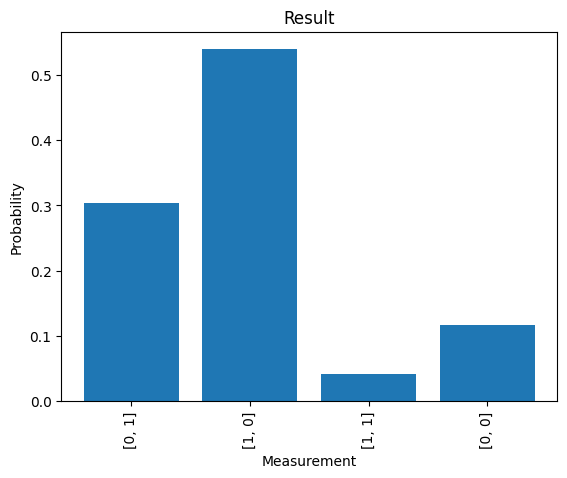

In [11]:
print(result)
results = localSimulator(MeasureTrialState, result.x, 2, 1000)

plt.bar(results.keys(), results.values())

plt.title("Result")
plt.xlabel("Measurement")
plt.ylabel("Probability")

plt.xticks(rotation = 90)

plt.show()

### **Exercise #2.2**

Solve this problem for $C = 5$ using our three steps:
1. Define the problem, specifically the Hamiltonian.
2. Run VQE for the problem.
3. Examine the results.

#### **1. Define the problem, specifically the Hamiltonian.**

In [35]:
def Hamiltonian(state): return state[0] + state[1] - 5*(state[0]*state[1])

##### **Run the code below to see all possible states and their energies.** (Physicists call this the *energy spectrum*.)

In [36]:
printFullSpectrum(2, Hamiltonian)

[0, 0] 0
[0, 1] 1
[1, 0] 1
[1, 1] -3


#### **2. Run VQE for the problem.**

In [37]:
VQE(2, Hamiltonian)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.0000000000000002
       x: [ 9.142e+03 -1.719e+04 -9.158e+04 -1.632e+04]
     nit: 6
     jac: [-1.342e+07 -1.342e+07 -1.342e+07  0.000e+00]
    nfev: 91
    njev: 6

#### **3. Examine the results.**

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.8499999999999999
       x: [ 6.554e+03  1.311e+04  9.831e+03  3.277e+03]
     nit: 1
     jac: [-6.711e+06 -1.342e+07 -1.007e+07 -3.355e+06]
    nfev: 16
    njev: 1


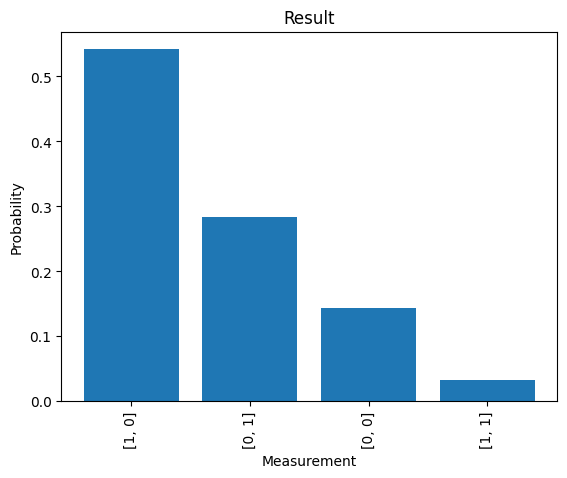

In [38]:
print(result)
results = localSimulator(MeasureTrialState, result.x, 2, 1000)

plt.bar(results.keys(), results.values())

plt.title("Result")
plt.xlabel("Measurement")
plt.ylabel("Probability")

plt.xticks(rotation = 90)

plt.show()

### **Exercise #2.3**

Solve this problem for $C = 2$ using our three steps:
1. Define the problem, specifically the Hamiltonian.
2. Run VQE for the problem.
3. Examine the results.

#### **1. Define the problem, specifically the Hamiltonian.**

In [39]:
def Hamiltonian(state): return state[0] + state[1] - 2*(state[0]*state[1])

##### **Run the code below to see all possible states and their energies.** (Physicists call this the *energy spectrum*.)

In [40]:
printFullSpectrum(2, Hamiltonian)

[0, 0] 0
[0, 1] 1
[1, 0] 1
[1, 1] 0


#### **2. Run VQE for the problem.**

In [41]:
result = VQE(2, Hamiltonian)

#### **3. Examine the results.**

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2
       x: [ 1.047e+06  1.197e+05  6.434e+05  1.087e+06]
     nit: 2
     jac: [-6.711e+06 -1.007e+07 -1.342e+07 -1.007e+07]
    nfev: 31
    njev: 2


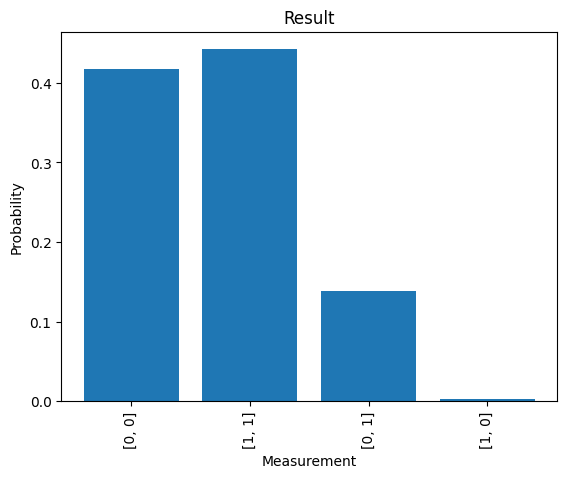

In [42]:
print(result)
results = localSimulator(MeasureTrialState, result.x, 2, 1000)

plt.bar(results.keys(), results.values())

plt.title("Result")
plt.xlabel("Measurement")
plt.ylabel("Probability")

plt.xticks(rotation = 90)

plt.show()

## **Part #3: Solving the Knapsack Problem**
---

Now, we will use VQE to solve the Knapsack Problem as described below.

Given $n$ items with values, $\{ \text{value}_1, \text{value}_2, ..., \text{value}_n\}$, and weights, $\{\text{weight}_1, \text{weight}_2, ..., \text{weight}_n\}$, we want to find the combination of items to put in our knapsack that have the greatest total value without going over a given weight limit, $\text{maxWeight}$. We can express this with the following Hamiltonian:

$H = -\sum_{i=1}^n{\text{value}_i * x_i} + \text{penalty} * (\text{maxWeight} - \sum_{i=1}^n{\text{weight}_i * x_i} )^2$

<br>

**Run the code below to create a python function that converts a problem to the Hamiltonian.**

In [83]:
def KnapsackProblem(state, value, weight, maxWeight):

    n = len(value)
    penalty = sum(value)/maxWeight**2 * 10

    # return -1*sum(value[i]*state[i] for i in range(n)) + penalty * (maxWeight - sum(weight[i]*state[i] for i in range(n)))**2)
    return -1*(sum(value[i]*state[i] for i in range(n)) + penalty * (maxWeight - sum(weight[i]*state[i] for i in range(n)))**2)

### **Exercise #3.1: Defining and Solving the Knapsack Problem with VQE (Practice Together)**

We will starting by solving this problem for the set of parameters given below using our three steps:
1. Define the problem, specifically the Hamiltonian.
2. Run VQE for the problem.
3. Examine the results.

<br>

**Problem Description**:
* $n = 3$
* $\text{value} = \{6, 10, 15 \}$
* $\text{weight} = \{10, 50, 75\}$
* $\text{maxWeight} = 100$

#### **1. Define the problem, specifically the Hamiltonian.**

In [84]:
def Hamiltonian(state): return KnapsackProblem(state, 
                                               value = [6, 10, 15], 
                                               weight = [10, 50, 75], 
                                               maxWeight = 100)

##### **Run the code below to see all possible states and their energies.** (Physicists call this the *energy spectrum*.)

In [85]:
printFullSpectrum(3,Hamiltonian)

[0, 0, 0] -310.0
[0, 0, 1] -34.375
[0, 1, 0] -87.5
[0, 1, 1] -44.375
[1, 0, 0] -257.1
[1, 0, 1] -27.975
[1, 1, 0] -65.6
[1, 1, 1] -68.975


#### **2. Run VQE for the problem.**

In [ ]:
result = VQE(3, Hamiltonian)

#### **3. Examine the results.**

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2
       x: [ 1.047e+06  1.197e+05  6.434e+05  1.087e+06]
     nit: 2
     jac: [-6.711e+06 -1.007e+07 -1.342e+07 -1.007e+07]
    nfev: 31
    njev: 2


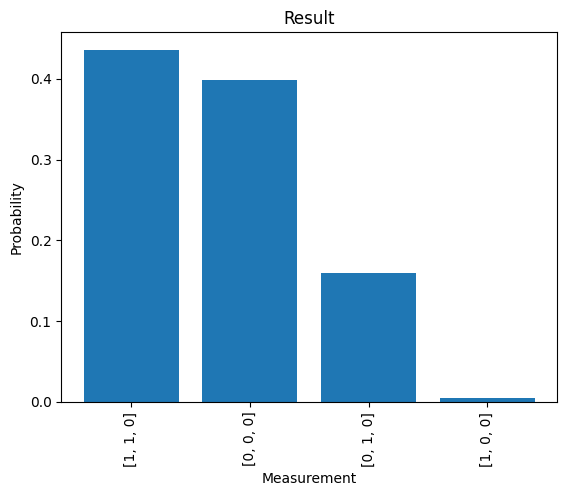

In [88]:
print(result)
results = localSimulator(MeasureTrialState, result.x, 3, 1000)

plt.bar(results.keys(), results.values())

plt.title("Result")
plt.xlabel("Measurement")
plt.ylabel("Probability")

plt.xticks(rotation = 90)

plt.show()

### **Exercise #3.2**

Now solve this problem for the set of parameters given below using our three steps:
1. Define the problem, specifically the Hamiltonian.
2. Run VQE for the problem.
3. Examine the results.

<br>

**Problem Description**:
* $n = 3$
* $\text{value} = \{6, 10, 15 \}$
* $\text{weight} = \{10, 50, 75\}$
* $\text{maxWeight} = 150$

#### **1. Define the problem, specifically the Hamiltonian.**

In [90]:
#COMPLETE THIS COMMAND
def Hamiltonian(state): return KnapsackProblem(state, 
                                               value = [6,10,15], 
                                               weight = [10,50,75] , 
                                               maxWeight = 150 )

##### **Run the code below to see all possible states and their energies.** (Physicists call this the *energy spectrum*.)

In [91]:
printFullSpectrum(3, Hamiltonian)

[0, 0, 0] -310.0
[0, 0, 1] -92.5
[0, 1, 0] -147.77777777777777
[0, 1, 1] -33.611111111111114
[1, 0, 0] -276.0444444444444
[1, 0, 1] -79.21111111111111
[1, 1, 0] -127.6
[1, 1, 1] -34.1


#### **2. Run VQE for the problem.**

In [ ]:
result = VQE(3, Hamiltonian)

#### **3. Examine the results.**

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2
       x: [ 1.047e+06  1.197e+05  6.434e+05  1.087e+06]
     nit: 2
     jac: [-6.711e+06 -1.007e+07 -1.342e+07 -1.007e+07]
    nfev: 31
    njev: 2


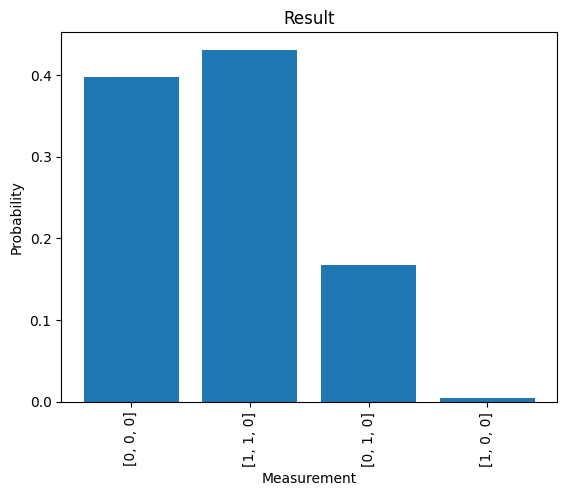

In [93]:
print(result)
results = localSimulator(MeasureTrialState, result.x, 3, 1000)

plt.bar(results.keys(), results.values())

plt.title("Result")
plt.xlabel("Measurement")
plt.ylabel("Probability")

plt.xticks(rotation = 90)

plt.show()

### **Exercise #3.3**

Now solve this problem for the set of parameters given below using our three steps:
1. Define the problem, specifically the Hamiltonian.
2. Run VQE for the problem.
3. Examine the results.

<br>

**Problem Description**:
* $n = 4$
* $\text{value} = \{6, 10, 15, 14 \}$
* $\text{weight} = \{10, 50, 75, 25\}$
* $\text{maxWeight} = 100$

#### **1. Define the problem, specifically the Hamiltonian.**

In [94]:
#COMPLETE THIS COMMAND
def Hamiltonian(state): return KnapsackProblem(state, 
                                               value = [6,10,15,14], 
                                               weight = [10,50,75,25], 
                                               maxWeight = 100)

##### **Run the code below to see all possible states and their energies.** (Physicists call this the *energy spectrum*.)

In [95]:
printFullSpectrum(4, Hamiltonian)

[0, 0, 0, 0] -450.0
[0, 0, 0, 1] -267.125
[0, 0, 1, 0] -43.125
[0, 0, 1, 1] -29.0
[0, 1, 0, 0] -122.5
[0, 1, 0, 1] -52.125
[0, 1, 1, 0] -53.125
[0, 1, 1, 1] -151.5
[1, 0, 0, 0] -370.5
[1, 0, 0, 1] -210.125
[1, 0, 1, 0] -31.125
[1, 0, 1, 1] -39.5
[1, 1, 0, 0] -88.0
[1, 1, 0, 1] -40.125
[1, 1, 1, 0] -86.125
[1, 1, 1, 1] -207.0


#### **2. Run VQE for the problem.**

In [ ]:
result = VQE(4, Hamiltonian)

#### **3. Examine the results.**

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2
       x: [ 1.047e+06  1.197e+05  6.434e+05  1.087e+06]
     nit: 2
     jac: [-6.711e+06 -1.007e+07 -1.342e+07 -1.007e+07]
    nfev: 31
    njev: 2


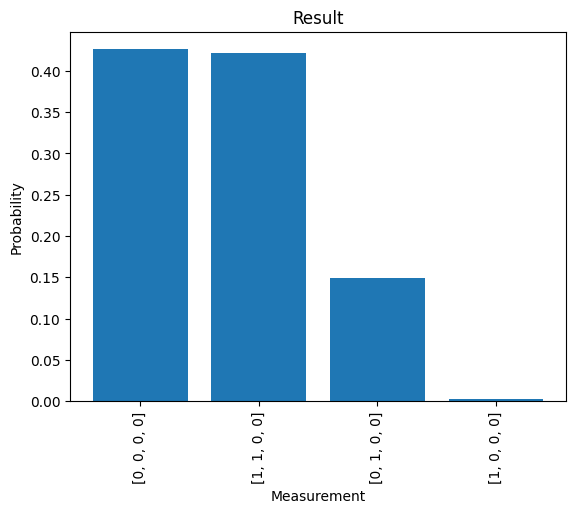

In [96]:
print(result)
results = localSimulator(MeasureTrialState, result.x, 4, 1000)

plt.bar(results.keys(), results.values())

plt.title("Result")
plt.xlabel("Measurement")
plt.ylabel("Probability")

plt.xticks(rotation = 90)

plt.show()

### **Exercise #3.4: Running On a Target. (Practice Together)**

Let's try solving this problem using the IonQ simulator. Specifically, we will:
1. Modify the code below so that the average energy function uses the currently connected target to get the results instead of running locally. 
2. Connect to a target of your choice.
3. Solve the problem above using this target.
4. Examine the results.

<br>

**NOTE**: While we could easily use a hardware target, this is not advisable since we need to each run a large number of different jobs. Generally, we need to run 100s of jobs to complete VQE, each of which could take a half hour or more. When researchers are running these jobs on real hardware, they often get special access to machines individually *and* modify their code to be extremely efficient (even if it's not as easy to understand).

#### **1. Modify the code below so that the average energy function uses the currently connected target to get the results instead of running locally.**

In [97]:
def averageEnergy(parameters, numQubits, Hamiltonian, shots = 100):

    # Prepare and measure the state many times
    results = localSimulator(MeasureTrialState, parameters, numQubits, shots)


    # Calculate and return the average energy of this set of measurements
    averageEnergy = 0
    for bits in results.keys():
        state = json.loads(bits)
        averageEnergy += Hamiltonian(state) * results[bits]
    
    return averageEnergy

#### **2. Connect to a target of your choice.**

Let's connect to the `"ionq.simulator"`.

In [98]:
qsharp.azure.target("ionq.simulator")

Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.simulator


{'id': 'ionq.simulator', 'current_availability': {}, 'average_queue_time': 2}

#### **3. Solve the problem above using this target.**

In [ ]:
result = VQE(4, Hamiltonian)

#### **3. Examine the results.**

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2
       x: [ 1.047e+06  1.197e+05  6.434e+05  1.087e+06]
     nit: 2
     jac: [-6.711e+06 -1.007e+07 -1.342e+07 -1.007e+07]
    nfev: 31
    njev: 2


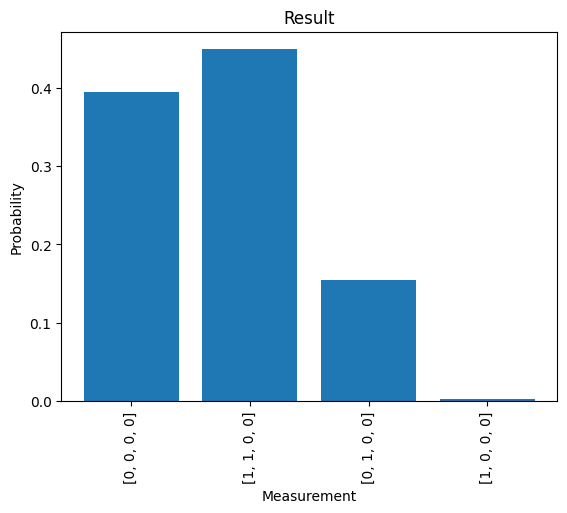

In [100]:
print(result)
results = localSimulator(MeasureTrialState, result.x, 4, 1000)

plt.bar(results.keys(), results.values())

plt.title("Result")
plt.xlabel("Measurement")
plt.ylabel("Probability")

plt.xticks(rotation = 90)

plt.show()

## **Part #4: Solving the Portfolio Optimization Problem**
---

In this section, we will use the tools we've developed above to solve a real world problem, using real world data. In particular, we will look at the historical data for 5 prominent stocks (Apple, Netflix, Amazon, IBM, and Google) and use VQE to determine the best set to buy from these moving forward.

We can modify the Knapsack problem to optimize which set of stocks we buy. In particular,
* Our "knapsack" will be the portfolio of stocks we buy.
* Each item will be a stock we are thinking about buying.
* The value of each stock will be its expected return after some time.
* The weight of each stock will be how much it costs to purchase it.
* The weight limit will then be our budget.

The only actual modification that professionals would suggest making to this problem is to consider *how risky* a given portfolio might be over a given time period. This can be calculated using something known as the *covariance*, which we will provide.

<br>

The overall Hamiltonian is then modified from

$H = -\sum_{i=1}^n{\text{value}_i * x_i} + \text{penalty} * (\text{maxWeight} - \sum_{i=1}^n{\text{weight}_i * x_i} )^2$

to

$H = -\sum_{i=1}^n{\text{expectedReturn}_i * x_i} + \text{penalty} * (\text{budget} - \sum_{i=1}^{n}{\text{cost}_i * x_i} )^2 + \text{riskPenalty}\sum_{i,j=1}^{n}{\text{covariance}_{i,j} x_i x_j}$

<br>

**Run the code below to load in the data and create a python function that converts a problem to the Hamiltonian.**

In [101]:
# LOAD DATA
#===========
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTi5CXvfD9dMKL6147_1FpcdCXygr-7fc0PwxVTjGKXseQF__vXsOO-VQdqzxBhTHYMYQTIrLc6rSLh/pub?gid=1706580062&single=true&output=csv"
df = pd.read_csv(url)

returns = []

for i in range(1, len(df.columns)):
  returns += [[]]
  data = df[df.columns[i]]
  for j in range(1, len(df)):
    diff = data[j] - data[j - 1]
    returns[i - 1] += [diff]
    
    
# DEFINE GENERAL HAMILTONIAN
#=============================
def PortfolioOptimization(state, expectedReturn, cost, budget, covariance):

  n = len(expectedReturn)
  penalty = sum(expectedReturn)/budget**2 * 15
  riskPenalty = 5/sum(sum(covariance[i][j] for j in range(n) for i in range(n)))

  return -1*sum(expectedReturn[i]*state[i] for i in range(n)) + penalty * (sum(cost[i]*state[i] for i in range(n)) - budget)**2 + riskPenalty * sum(sum(covariance[i][j] * state[i] * state[j] for j in range(n)) for i in range(n))

### **Exercise #4.1: Visualize the Data (Practice Together)**

It is vital to explore and visualize data before using it. **Run the code below to visualize this data.**


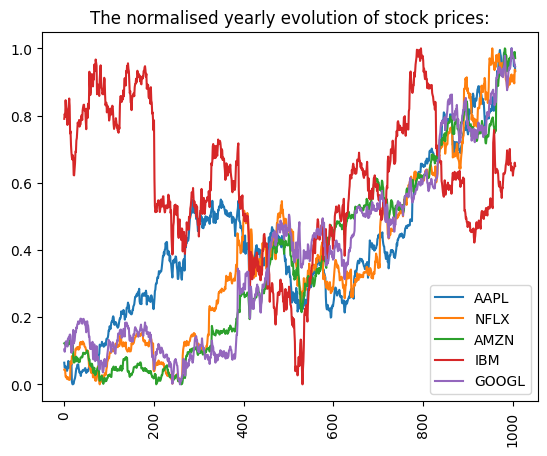

In [102]:
for ticker in df.columns[1:]:
    stockData = df[ticker]
    norm = (stockData - stockData.min())/(stockData.max()- stockData.min())
    plt.plot(norm, label=ticker)

plt.legend()
plt.title("The normalised yearly evolution of stock prices:")
plt.xticks(rotation=90)
plt.show()

### **Exercise #4.2: Defining and Solving Portfolio Optimization with VQE (Practice Together)**

We will starting by solving this problem for the set of parameters given below using our three steps:
1. Define the problem, specifically the Hamiltonian.
2. Run VQE for the problem.
3. Examine the results.

<br>

**Problem Description**:
* $n = 5$  (Apple, Netflix, Amazon, IBM, and Google)
* $\text{expectedReturn} = \text{average historical returns}$
* $\text{covariance} = \text{covariance of historical data}$
* $\text{cost} = \{1, 1, 1, 1, 1\}$
* $\text{budget} = 3$

#### **1. Define the problem, specifically the Hamiltonian.**

In [103]:
expectedReturn = pd.DataFrame(returns).transpose().mean().tolist()
covariance = df.cov().values.tolist()

cost = [1, 1, 1, 1, 1]
budget = 3


def Hamiltonian(state): return PortfolioOptimization(state, expectedReturn, cost, budget, covariance)